## Import modules

In [2]:
# local
import DBSCAN as ds

import numpy as np
import pandas as pd

from collections import Counter

# nltk 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import stop_words as sw

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


# data scraping
import itertools
import snscrape.modules.twitter as sc_twt

# visualisation
import seaborn as sns
import wordcloud as wc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

## Data Scrapping

In [3]:
def  scrape_and_save(search_str: str, file_name: str, num_tweets: int = 2000, slice: bool = True):

    scraped_tweets = sc_twt.TwitterSearchScraper(search_str).get_items()

    if(slice):
        sliced_scraped_tweets = itertools.islice(scraped_tweets, num_tweets)
        df = pd.DataFrame(sliced_scraped_tweets)
    else:
        df = pd.DataFrame(scraped_tweets)

    if df.empty == False:
        scr = pd.DataFrame.copy( df[['id', 'date', 'user', 'media', 'lang', 'content', 'hashtags', 'likeCount', 'replyCount', 'quoteCount']])

        scr['user_name'] = scr['user'].apply(lambda x: x['username'])
        scr['user_location'] =  scr['user'].apply(lambda x: x['location'])
        scr['user_isprotected'] = scr['user'].apply(lambda x: x['protected'])
        scr['user_isverified'] = scr['user'].apply(lambda x: x['verified'])

        scr = scr.drop(columns=['user'])

        print("num scraped tweets:" + str(scr.count()))
        print(scr.head(5))
        scr.to_csv(file_name)
    else:
        print("empty df")

In [4]:
# get tweets in english
from os.path import exists

tweets_file = "data/scraped_tweets.csv"
file_exists = exists(tweets_file)

if not file_exists:
    en_search = '(WorldCup OR WorldCup2022 OR FifaWorldCup) until:2022-11-10 lang:en'
    scrape_and_save(search_str = en_search, file_name = "data/scraped_tweets.csv", slice = True, num_tweets=60000)

## Data preprocessing

In [5]:
from os.path import exists

tweets_file = "data/tweets_processed.csv"
tweets_processed_file = exists(tweets_file)
tweets_processed_file

True

### Read data

In [6]:
if not tweets_processed_file:
    df_en_tweets = pd.read_csv("data/scraped_tweets.csv", delimiter=',')
    print(df_en_tweets.head(2))

### clean columns

#### Ensure that pl tweets in en are just in english

In [7]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets.loc[df_en_tweets['lang'] == 'en']
    df_en_tweets.info()

##### add new, simpler index

In [8]:
# create new index
if not tweets_processed_file:
    df_en_tweets.insert(0, 'ID', range(0, len(df_en_tweets)))
    df_en_tweets = df_en_tweets.set_index('ID')
    print(df_en_tweets.head(3))

In [9]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets[['lang', 'content', 'user_location']]
    print(df_en_tweets.head(3))

#### Encode location column

In [10]:
if not tweets_processed_file:
    oe = OrdinalEncoder()
    df_en_tweets['location'] = df_en_tweets['user_location']
    df_en_tweets['location'] = oe.fit_transform(np.array(df_en_tweets['location']).reshape(-1, 1))
    df_en_tweets = df_en_tweets.drop(columns = ['user_location'])
    df_en_tweets.info()

### Clean text content

In [11]:
if not tweets_processed_file:
    white_spaces = ["\r", "\n","\t", "    "]
    punctuation_signs = list("?:!.,;")
    special_characters = list("@#")


    df_en_tweets['content_clean_1'] = df_en_tweets['content']

    # whitespaces
    for char in white_spaces:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(char, " ")

    # quotation marks
    df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace('"', '')


    # puncuation signs
    for sign in punctuation_signs:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(sign, '')
    df_en_tweets.head()

In [12]:
if not tweets_processed_file:
    df_en_tweets.info()

In [13]:
if not tweets_processed_file:
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("t20") == False]
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("T20") == False]
   df_en_tweets.info()

In [14]:
if not tweets_processed_file:
    hashtag_regex = "(#)(((\S)|(\d))*)"
    tag_regex = "(@)(((\S)|(\d))*)"
    link_regex = "(http)((\S|\d))*"

    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_1'].str.replace(pat=hashtag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=tag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=link_regex, repl= "")

In [15]:
if not tweets_processed_file:
        import re 
        emoji_regex = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                        "]+", re.UNICODE)

        df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_2'].str.replace(pat=emoji_regex, repl= " ")

In [16]:
if not tweets_processed_file:
    df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_3'].str.replace("’s", "")
    df_en_tweets['content_clean_4'] = df_en_tweets['content_clean_3'].str.replace("'", "")
    df_en_tweets['content_clean_5'] = df_en_tweets['content_clean_4'].str.lower()
    print(df_en_tweets.head())

#### Lemmatize and remove stopwords

In [17]:
if not tweets_processed_file:
    lemmatizer = WordNetLemmatizer()
    stop_words_en = sw.get_stop_words(language="english")

    df_en_tweets['content_clean_6'] = df_en_tweets['content_clean_5']

    lemmatized_texts = []

    for row in df_en_tweets['content_clean_6']:
        text = row
        word_tokens = text.split(" ")

        lemmas  = []
        lemmatized_text = []

        for word in word_tokens:
            if word not in stop_words_en:
                lemmas.append(lemmatizer.lemmatize(word, pos = 'v'))

        lemmatized_text = " ".join(lemmas)

        lemmatized_texts.append(lemmatized_text)
        
    df_en_tweets['content_clean_7']= lemmatized_texts
    print(df_en_tweets.head())

In [18]:
if not tweets_processed_file:
    df_en_tweets['text'] = df_en_tweets['content_clean_7']
    df_en = df_en_tweets[['text']]
    print(df_en.head())    

In [19]:
if not tweets_processed_file:
    df_en.to_csv("data/tweets_processed.csv")

## Data Analysis

In [20]:
tweets_df = pd.read_csv("data/tweets_processed.csv")
tweets_df.head()

,ID,text
0,0,can never world cup uphold basic human right ...
1,1,french national team announce roster
2,2,us mens national team set roster world cup go...
3,3,sick joke now maddison tomori get man now
4,4,update quote inter miami defender deandre yedl...


In [21]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54482 entries, 0 to 54481
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      54482 non-null  int64 
 1   text    54479 non-null  object
dtypes: int64(1), object(1)
memory usage: 851.4+ KB


In [22]:
tweets_df = tweets_df.dropna()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54479 entries, 0 to 54481
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      54479 non-null  int64 
 1   text    54479 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [23]:
def words_per_sample(list_of_texts: list):
    
    num_words = [len(s.split(' ')) for s in list_of_texts]
    return np.median(num_words)

def plot_sample_length_distr(sample_texts):
    """Plots the sample length distribution.
    """

    num_words = [len(s.split()) for s in sample_texts]
    plt.hist(num_words, 50)
    plt.xlabel('Length of a sample [words]')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [24]:
words_per_sample = words_per_sample(tweets_df["text"])
print(f"\n Median number of words per sample: {words_per_sample}")


 Median number of words per sample: 11.0


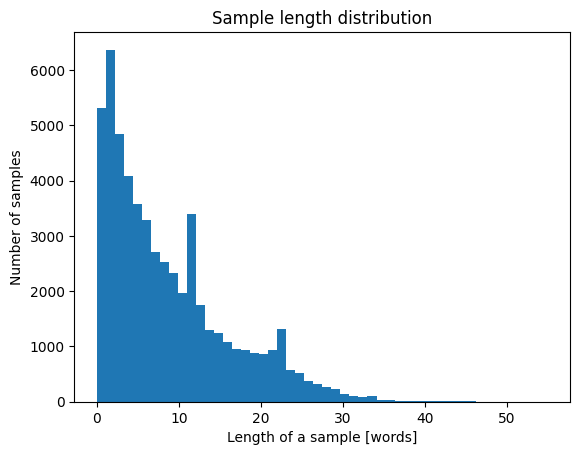

In [25]:
plot_sample_length_distr(tweets_df["text"])

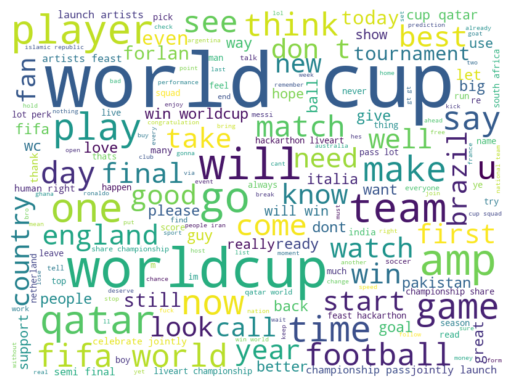

In [26]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenization and creating tweets embeddings

In [27]:
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
import torch

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [29]:
tweets_df['tokenized'] = ''
tweets_df['tokens'] = ''
tweets_df['attention_mask'] = ''

In [30]:
tokenized_data = tokenizer(tweets_df["text"].values.tolist(), padding=True, truncation=True)
tokenized_data[0]

Encoding(num_tokens=102, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [31]:
i = 0
for row in tweets_df.itertuples():

    tweets_df['tokenized'][i] = tokenized_data[i].ids
    tweets_df['tokens'][i] = tokenized_data[i].tokens
    tweets_df['attention_mask'][i] = tokenized_data[i].attention_mask
    i = i +1

C:\Users\kasia\AppData\Local\Temp\ipykernel_5308\4026262543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized'][i] = tokenized_data[i].ids
C:\Users\kasia\AppData\Local\Temp\ipykernel_5308\4026262543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokens'][i] = tokenized_data[i].tokens
C:\Users\kasia\AppData\Local\Temp\ipykernel_5308\4026262543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twe

In [32]:
tweets_df.head()

,ID,text,tokenized,tokens,attention_mask
0,0,can never world cup uphold basic human right ...,"[0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...","[<s>, can, never, world, cup, uphold, basic, h...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,french national team announce roster,"[0, 2417, 2124, 2140, 14974, 9242, 2, 1, 1, 1,...","[<s>, french, national, team, announce, roster...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,us mens national team set roster world cup go...,"[0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...","[<s>, us, men, ##s, national, team, set, roste...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,sick joke now maddison tomori get man now,"[0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...","[<s>, sick, joke, now, mad, ##dis, ##on, tom, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
4,4,update quote inter miami defender deandre yedl...,"[0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...","[<s>, update, quote, inter, miami, defender, d...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [33]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54479 entries, 0 to 54481
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              54479 non-null  int64 
 1   text            54479 non-null  object
 2   tokenized       54479 non-null  object
 3   tokens          54479 non-null  object
 4   attention_mask  54479 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.5+ MB


In [34]:
tweets_df = tweets_df[tweets_df['tokens'].apply(lambda x: len(x) > 3)]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54476 entries, 0 to 54478
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              54476 non-null  int64 
 1   text            54476 non-null  object
 2   tokenized       54476 non-null  object
 3   tokens          54476 non-null  object
 4   attention_mask  54476 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.5+ MB


### Represent text as Doc2Vec

In [35]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tokenized_texts = tweets_df['tokens'].values.tolist()
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_texts)]
tagged_data[0:2]

[TaggedDocument(words=['<s>', 'can', 'never', 'world', 'cup', 'uphold', 'basic', 'human', 'right', 'put', 'athletes', 'whose', 'job', 'place', 'work', 'in', '##vid', '##ious', 'position', 'fear', 'identity', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], tags=[0]),
 TaggedDocument(words=['<s>', 'french', 'national', 

In [36]:
model = Doc2Vec(vector_size = 20, window = 2, min_count = 1, epochs = 100)

In [37]:
model.build_vocab(tagged_data)

In [38]:
from os.path import exists

model_file = "d2v.model"
file_exists = exists(model_file)

if file_exists:
    model = Doc2Vec.load(model_file)
else:
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_file)

In [39]:
embeddings = [model.infer_vector(d) for i, d in enumerate(tokenized_texts)]

In [40]:
embeddings[0]

array([ 0.2467352 , -1.1536226 ,  1.3782895 ,  1.0023077 , -0.10765521,
        1.3224764 , -0.77446   ,  0.5688139 , -0.06594059,  0.9898625 ,
       -1.1915829 ,  0.5250177 ,  0.39741713, -0.45702076,  0.8969226 ,
        1.1174084 , -1.0372143 ,  0.09912731,  1.4294426 , -0.0486558 ],
      dtype=float32)

In [41]:
tweets_df['embeddings'] = embeddings

In [42]:
tweets_df.head()

,ID,text,tokenized,tokens,attention_mask,embeddings
0,0,can never world cup uphold basic human right ...,"[0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...","[<s>, can, never, world, cup, uphold, basic, h...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.2467352, -1.1536226, 1.3782895, 1.0023077, ..."
1,1,french national team announce roster,"[0, 2417, 2124, 2140, 14974, 9242, 2, 1, 1, 1,...","[<s>, french, national, team, announce, roster...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6302237, 0.08087413, 0.45965782, -0.3714863..."
2,2,us mens national team set roster world cup go...,"[0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...","[<s>, us, men, ##s, national, team, set, roste...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.14491315, 0.011052909, 0.44993034, -0.15426..."
3,3,sick joke now maddison tomori get man now,"[0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...","[<s>, sick, joke, now, mad, ##dis, ##on, tom, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0.9768819, 0.121740505, 0.5678517, 0.07165995..."
4,4,update quote inter miami defender deandre yedl...,"[0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...","[<s>, update, quote, inter, miami, defender, d...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.117786214, -0.25651518, 0.653688, -0.414808..."


## Experiments with DBSCAN

In [43]:
data = pd.DataFrame(tweets_df['embeddings'])
data.head()

,embeddings
0,"[0.2467352, -1.1536226, 1.3782895, 1.0023077, ..."
1,"[0.6302237, 0.08087413, 0.45965782, -0.3714863..."
2,"[0.14491315, 0.011052909, 0.44993034, -0.15426..."
3,"[0.9768819, 0.121740505, 0.5678517, 0.07165995..."
4,"[0.117786214, -0.25651518, 0.653688, -0.414808..."


### define helper functions

In [44]:
def reduce_dimensionality(df: pd.DataFrame, vec_col_name : str = 'embeddings'):
    data = df.copy()
    data = data.reset_index()
  
    pca = PCA(n_components=3)
    data['x1'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,0]
    data['x2'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,1]
    data['x3'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,2]

    return data[['x1','x2','x3']]

In [45]:
def plot_clusters(data: pd.DataFrame, clusters: list, plt_title: str, plt_title_3d: str, dest_folder: str, save: bool = False):

    # create and save 2d clusters plot ####
    clusters_plt_2d = sns.scatterplot(x = data['x1'], y= data['x2'],hue=clusters,data=data)
    plt.title(plt_title)

    # save
    if save is True:
        fig1 = clusters_plt_2d.get_figure()
        fig1.savefig(f"{dest_folder}\{plt_title}.png")

    # create 3d clusters plot ####

    # axes instance
    fig2 = plt.figure(figsize=(6,6))
    ax = Axes3D(fig2, auto_add_to_figure=False)
    fig2.add_axes(ax)

    # plot
    sc = ax.scatter( data['x1'], data['x2'], data['x3'], s=40, c=clusters, marker='o')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.title(plt_title_3d)

    # save
    if save is True:
        plt.savefig(f"{dest_folder}\{plt_title_3d}.png", bbox_inches='tight')

In [46]:
def apply_dbscan(data: pd.DataFrame, eps: int = 0.5, min_pts: int = 5, vec_col_name : str = 'embeddings', dist_measure: str = 'euclidean'):
    
    df = data.copy()
    
    df_cut = df[vec_col_name].apply(pd.Series)
    data_arr = np.array(df_cut)

    clusters, true_centers = ds.dbscan(data_arr, eps = eps, min_points=min_pts, dist_func=dist_measure)
    clusters_counter = Counter(clusters)

    return {'results': {'clusters': clusters, 'cluster_counter': clusters_counter, 'true_centers': true_centers}, 'df_cut': df_cut}

In [47]:
def get_reduced_df(df: pd.DataFrame, vec_col_name : str = 'embeddings'):
    # combine data back into one vector
    source_df = df.copy()
    source_df[vec_col_name] = source_df.values.tolist()

    # reduce dimensionality to 3
    reduced_df = reduce_dimensionality(source_df, vec_col_name)

    return reduced_df

### Experiments with input size, eps and min points params

#### input: first 2500 tweets

In [48]:
df_slice = data.loc[0:2499]
df_slice.count()

embeddings    2500
dtype: int64

##### attempt 1 : eps = 0.5, min_pts: 5

In [60]:
results = apply_dbscan(data = df_slice, eps = 0.5, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 2279, 1: 165, 7: 6, 5: 10, 2: 5, 3: 5, 4: 6, 8: 5, 6: 5, 9: 14})

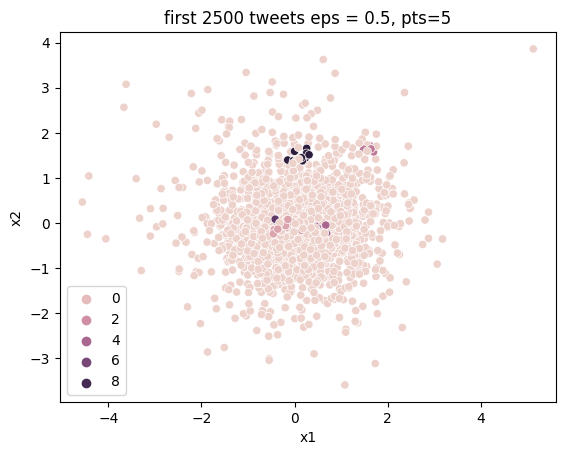

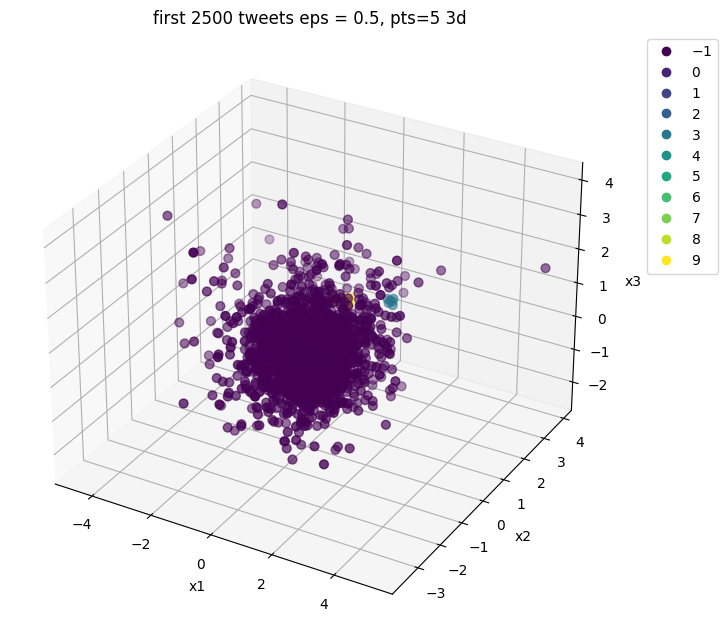

In [61]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 0.5, pts=5',
 plt_title_3d = 'first 2500 tweets eps = 0.5, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 2 : eps = 1, min_pts: 5

In [63]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 1925, 1: 549, 2: 6, 3: 6, 4: 14})

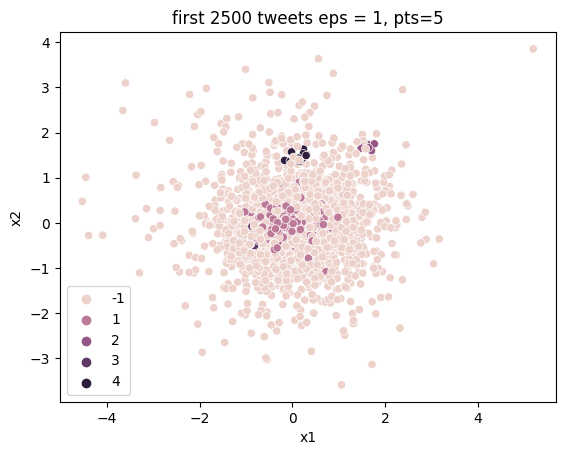

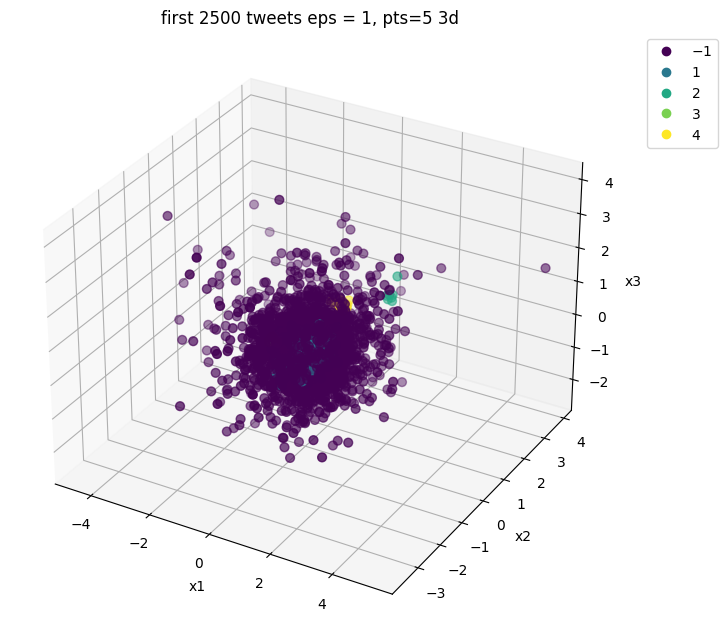

In [64]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 1, pts=5',
plt_title_3d = 'first 2500 tweets eps = 1, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 3 : eps = 1.5, min_pts: 5

In [65]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 1321, 1: 1154, 3: 5, 2: 6, 4: 14})

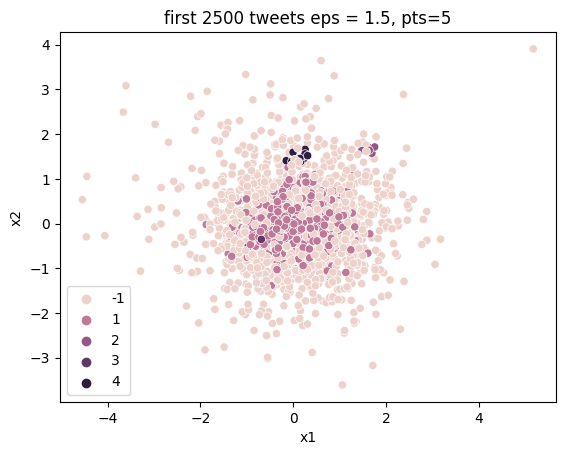

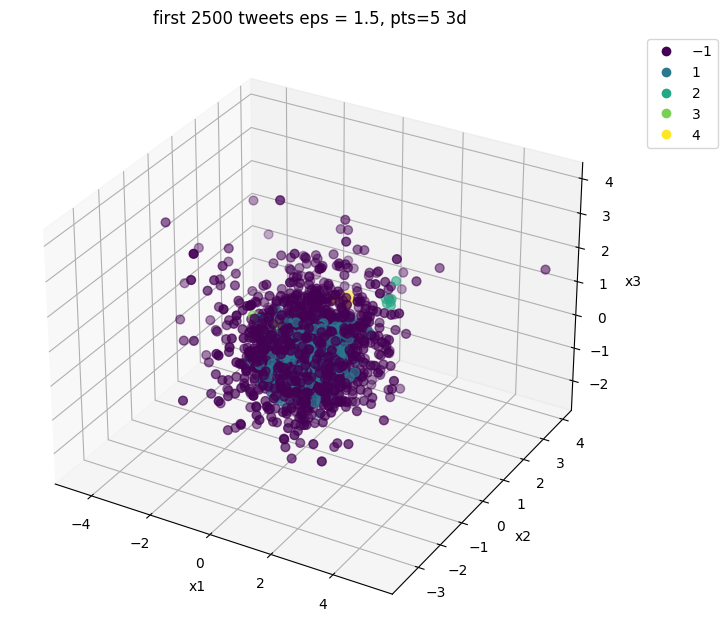

In [66]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 1.5, pts=5',
plt_title_3d = 'first 2500 tweets eps = 1.5, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 4 : eps = 2, min_pts: 5

In [49]:
results = apply_dbscan(data = df_slice, eps = 2, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 784, 1: 1709, 2: 7})

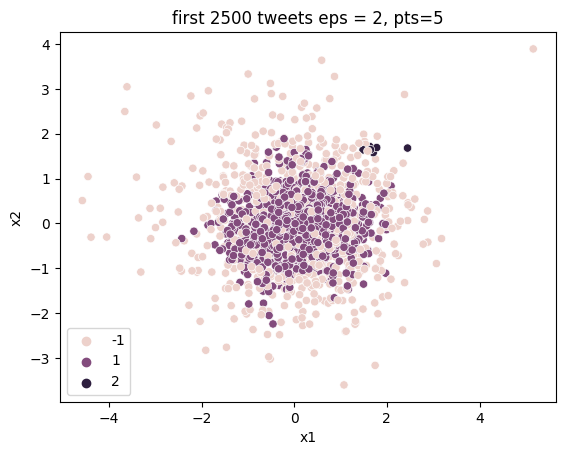

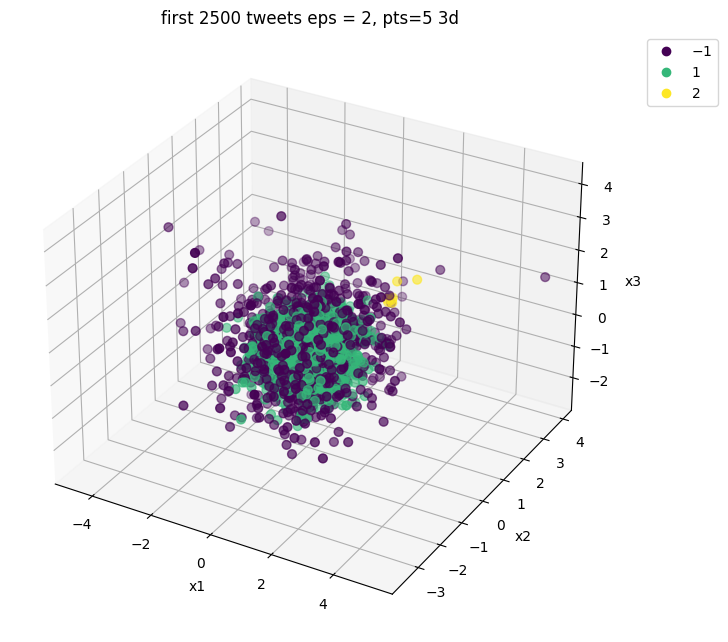

In [50]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 2, pts=5',
plt_title_3d = 'first 2500 tweets eps = 2, pts=5 3d', dest_folder = 'plots', save = True)

#### input: first 5000 tweets

In [1]:
df_slice = data.loc[0:4999]
df_slice.count()

NameError: name 'data' is not defined

##### attempt 1: eps = 0.5, min_pts = 5

In [ ]:
results = apply_dbscan(data = df_slice, eps = 0.5, min_pts=5)
results['results']['cluster_counter']

In [ ]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 0.5, pts=5',
 plt_title_3d = 'first 5000 tweets eps = 0.5, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 2 : eps = 1, min_pts: 5

In [ ]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=5)
results['results']['cluster_counter']

In [ ]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1, pts=5',
plt_title_3d = 'first 5000 tweets eps = 1, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 3 : eps = 1.5, min_pts: 5

In [ ]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=5)
results['results']['cluster_counter']

In [ ]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1.5, pts=5',
plt_title_3d = 'first 5000 tweets eps = 1.5, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 4 : eps = 2, min_pts: 5

In [ ]:
results = apply_dbscan(data = df_slice, eps = 2, min_pts=5)
results['results']['cluster_counter']

In [ ]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 2, pts=5',
plt_title_3d = 'first 5000 tweets eps = 2, pts=5 3d', dest_folder = 'plots', save = True)

### Experiments with choosing random tweets 

#### sample 5000 tweets

In [47]:
df_sample = data.copy().sample(5000)
df_sample.head(2)

,embeddings
41099,"[0.56029147, 0.34344003, 1.3131385, -0.0031492..."
49694,"[0.5283419, 0.70813674, 0.3348208, 0.3164612, ..."


##### attempt 1 : eps = 0.5, min_pts: 5

In [48]:
results = apply_dbscan(data = df_sample, eps = 0.5, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 4587,
         1: 326,
         2: 24,
         3: 6,
         4: 18,
         5: 5,
         6: 7,
         7: 12,
         8: 5,
         9: 5,
         10: 5})

In [49]:
data_to_visualize = get_reduced_df(results['df_cut']) 
data_to_visualize.head(2)

,x1,x2,x3
0,1.668149,-1.176827,-1.515038
1,-0.072818,-0.398477,-0.247818


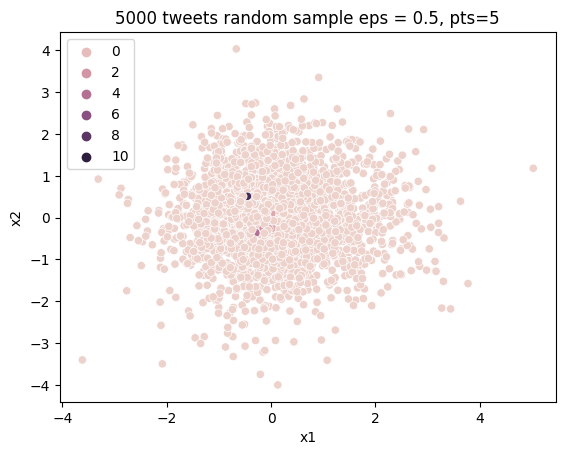

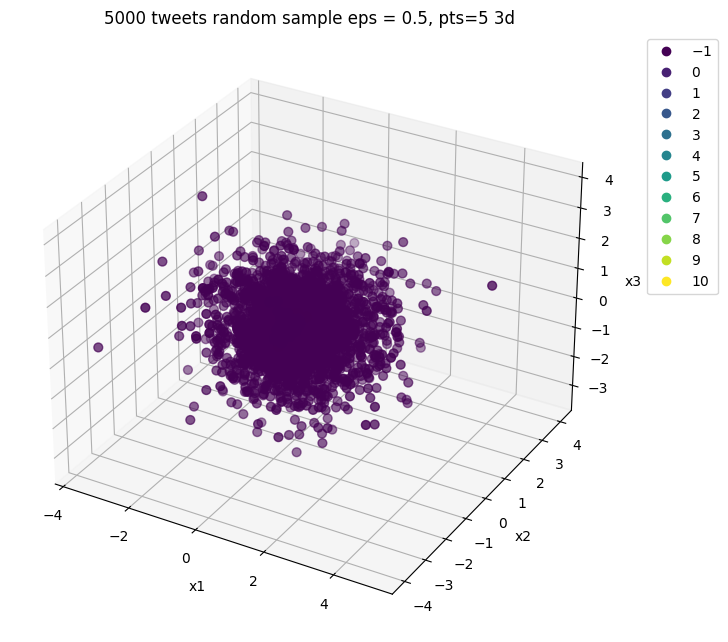

In [50]:
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = '5000 tweets random sample eps = 0.5, pts=5', 
plt_title_3d = '5000 tweets random sample eps = 0.5, pts=5 3d', dest_folder = 'plots', save=True)

##### attempt 2 : eps = 0.75, min_pts: 5

In [52]:
results = apply_dbscan(data = df_sample, eps = 0.75, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 4196, 4: 4, 1: 779, 2: 8, 3: 13})

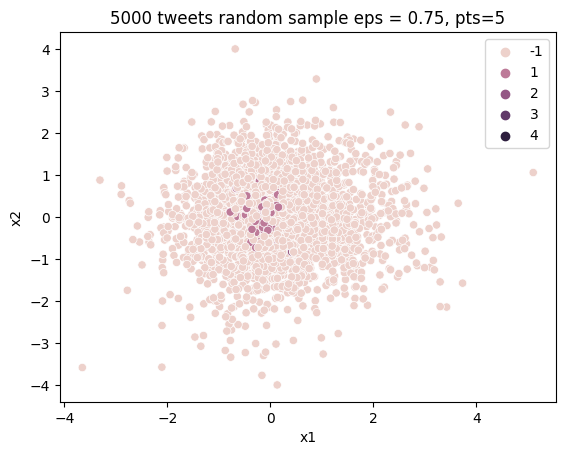

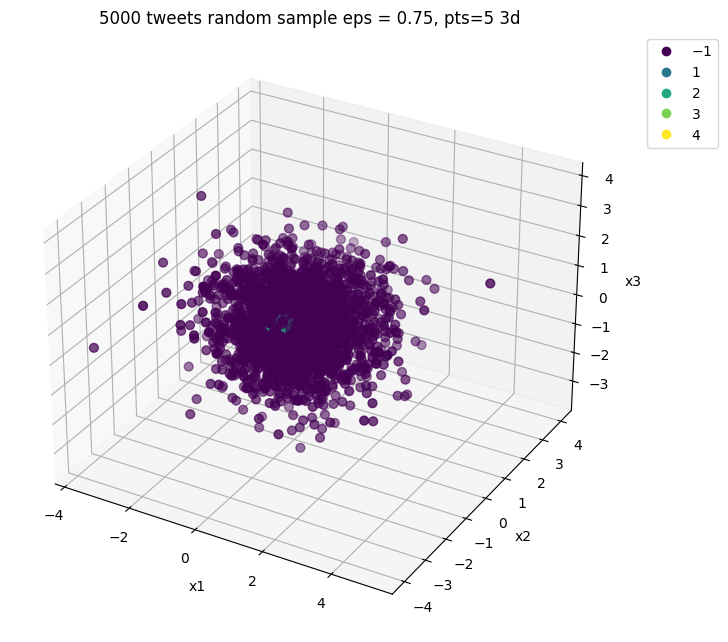

In [53]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = '5000 tweets random sample eps = 0.75, pts=5',
plt_title_3d = '5000 tweets random sample eps = 0.75, pts=5 3d', dest_folder = 'plots', save = True)

##### attempt 3: eps = 1, min_pts = 5

In [54]:
results = apply_dbscan(data = df_sample, eps = 1, min_pts=5)
results['results']['cluster_counter']

Counter({-1: 3610, 1: 1390})

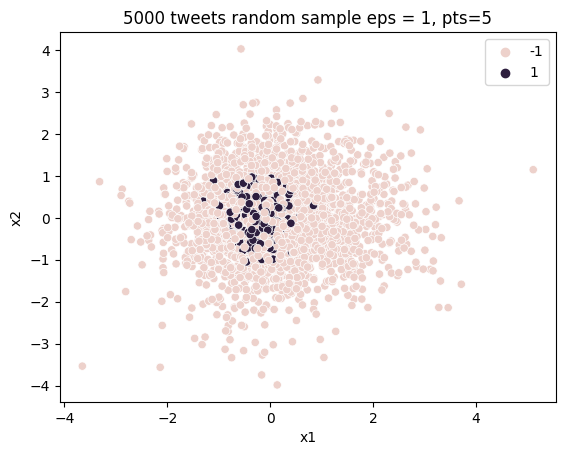

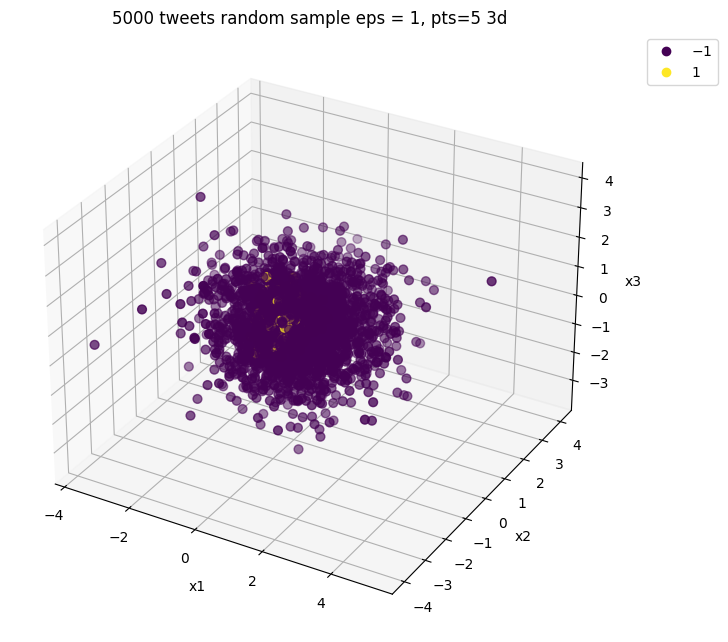

In [55]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = '5000 tweets random sample eps = 1, pts=5', 
plt_title_3d = '5000 tweets random sample eps = 1, pts=5 3d', dest_folder = 'plots', save= True)